# Week 4: NLP Disaster Tweets Kaggle Mini-Project

Loading the required modules below. 

In [370]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter

import keras
from keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


## Brief description of the problem and data (5 pts)

*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.*

This data set consists of tweets (text) and the training portion is labeled based on if the tweet is about a disaster or not. The objective is to create a model that can predict if a tweet is about a disaster or not. We will be using NLP tecnhiques, namely Long Short-Term Memory architecture, to classify the text/tweet. 

The data comes in csv-files. Training data has 7613 entries (6961 after removing duplicates). In addition to the text and the target label, the training set has id, location and keyword which are ignored in this work. The split between the two label is fairly even, 57/43. Testing data has 3236 entries. The tweets have different amount of words, up to 31 words. More basic information about the data is printed in the code below.


**************************************** Train dataset ****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   word_count  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB

Numerical statistics:
                  id      target   word_count
count   7613.000000  7613.00000  7613.000000
mean    5441.934848     0.42966    14.903586
std     3137.116090     0.49506     5.732604
min        1.000000     0.00000     1.000000
25%     2734.000000     0.00000    11.000000
50%     5408.000000     0.00000    15.000000
75%     8146.000000     1.00000    19.000000
max    10873.000000     1.00000    31.000

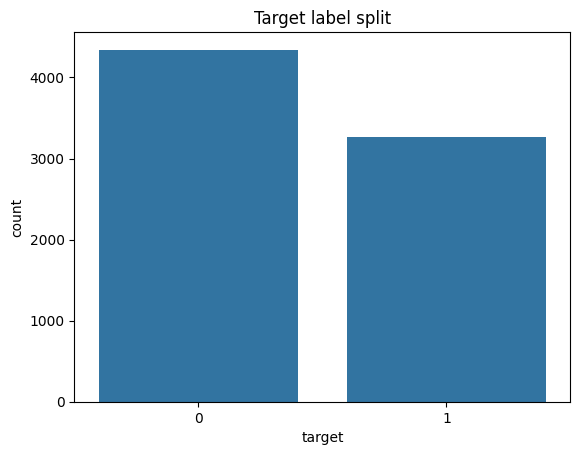


**************************************** Test dataset ****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3263 non-null   int64 
 1   keyword     3237 non-null   object
 2   location    2158 non-null   object
 3   text        3263 non-null   object
 4   word_count  3263 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 127.6+ KB

Numerical statistics:
                  id   word_count
count   3263.000000  3263.000000
mean    5427.152927    14.965369
std     3146.427221     5.783576
min        0.000000     1.000000
25%     2683.000000    11.000000
50%     5500.000000    15.000000
75%     8176.000000    19.000000
max    10875.000000    31.000000

    id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible ca

In [371]:
def count_words(df):
    for i, row in df.iterrows():
        df.loc[i, 'word_count'] = len(row.text.split())
        txt = df.loc[i, 'text']
        txt = re.sub(r'https?://\S+|www.\S+', '', txt) # Remove URLs
        txt = re.sub(r'[^a-z0-9A-Z\s]', '', txt) # Remove numbers
        # txt = txt.lower()
        df.loc[i, 'text'] = txt
    df['word_count'] = df['word_count'].astype(int)
    all_text = ' '.join(df.text)
    unique_words = len(set(all_text.split()))
    return unique_words

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_unique_words = count_words(train_df)
test_unique_words = count_words(test_df)

all_text = ' '.join(((pd.concat([train_df,test_df], axis=0)).text.values))
all_unique_words = len(set(all_text.split()))


print('\n' + 40*'*' + ' Train dataset ' + 40*'*')
train_df.info()
print('\nNumerical statistics:\n', train_df.describe())
print('\n', train_df.head(4), '\n')
# print('\n', train_df.tail(3))
print('Number of duplicated rows:', np.sum(train_df.duplicated()))
print('Number of duplicated texts:', np.sum(train_df.duplicated(subset='text')))
print('Longest tweet has', np.max(train_df.word_count), 'words.')
print('Unique words in the dataset:', train_unique_words)
print('Target values:', pd.unique(train_df.target))
y_split = round(100 * np.sum(train_df.target == 1)/len(train_df.target))
print('Target split: \n1 (disaster) =', y_split, '%\n0 (not disaster) =', 100-y_split, '%')
sns.countplot(train_df, x='target')
plt.title('Target label split')
plt.show()

print('\n' + 40*'*' + ' Test dataset ' + 40*'*')
test_df.info()
print('\nNumerical statistics:\n', test_df.describe())
print('\n', test_df.head(4), '\n')
# print('\n', test_df.tail(3))
print('Number of duplicated rows:', np.sum(test_df.duplicated()))
print('Number of duplicated texts:', np.sum(test_df.duplicated(subset='text')))
print('Longest tweet has', np.max(test_df.word_count), 'words.')
print('Unique words in the dataset:', test_unique_words)


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

Checking the general structure of the data. Check and remove potential duplicates from the training set. 

In [372]:
print('Size with duplicated texts:', len(train_df))
train_df.drop_duplicates(subset='text', inplace=True)
print('Size without duplicated texts:', len(train_df))

Size with duplicated texts: 7613
Size without duplicated texts: 6961


Checking the distribution of word counts in each tweet. Distibutions seem identical in the training and testing sets. 

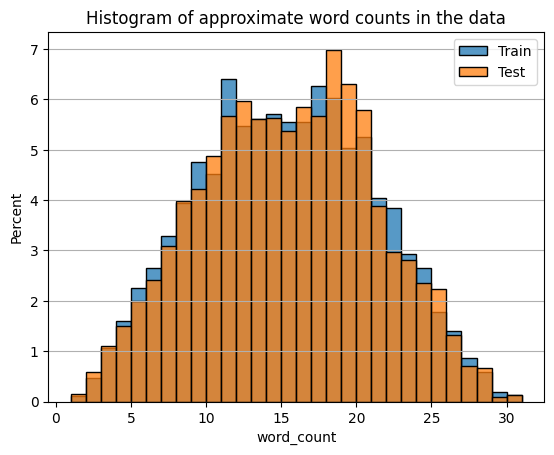

In [373]:
sns.histplot(train_df, x='word_count', bins=30, stat='percent')
sns.histplot(test_df, x='word_count', bins=30, stat='percent')
plt.grid(axis='y')
plt.title('Histogram of approximate word counts in the data')
plt.legend(['Train','Test'])
plt.show()


In [374]:
all_text = pd.concat([train_df,test_df], axis=0).text.values

## Model Architecture (25 pts)

*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.*

*Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.*

*There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.*

*Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).*

Using a word tokenization below to map the words. The resulting matrix is also padded to the length of the longest tweet, 31 words. 

A few examples from training and testing data are shown.

### Text to matrix

In [403]:
max_features = 5000

In [404]:
my_vectorizer = keras.layers.TextVectorization(
    max_tokens=max_features,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=1,
    output_mode="int",
    output_sequence_length=None,
    pad_to_max_tokens=True,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding="utf-8",
    name=None,
)
my_vectorizer.adapt(train_df['text'])
x_train = my_vectorizer(train_df['text'])
x_test = my_vectorizer(test_df['text'])
y_train = train_df.target

def check_vector(vect, text):
    print('Shape:', vect.shape)
    print('Min and max:', np.min(vect), np.max(vect))
    for txt, vec in zip(text[0:3], vect[0:3]):
        print(txt, '\n', vec[0:15])

print('Training:')
check_vector(x_train, train_df['text'])
print()
print('Testing:')
check_vector(x_test, test_df['text'])

Training:
Shape: (6961, 31)
Min and max: 0 4999
Our Deeds are the Reason of this earthquake May ALLAH Forgive us all 
 tf.Tensor(
[ 101    1   22    2  735    6   18  219  135 1904    1   65   38    0
    0], shape=(15,), dtype=int64)
Forest fire near La Ronge Sask Canada 
 tf.Tensor(
[ 186   42  193  713    1    1 1289    0    0    0    0    0    0    0
    0], shape=(15,), dtype=int64)
All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected 
 tf.Tensor(
[  38 1605 1539    4 1974    5  605   22  123    1   19 1620   40  323
  236], shape=(15,), dtype=int64)

Testing:
Shape: (3263, 31)
Min and max: 0 4998
Just happened a terrible car crash 
 tf.Tensor(
[  27  787    3 1738  133   98    0    0    0    0    0    0    0    0
    0], shape=(15,), dtype=int64)
Heard about earthquake is different cities stay safe everyone 
 tf.Tensor(
[ 382   51  219    9 1030 2530  501 1769  196    0    0    0    0    0
    0], shape

Also a TF-IDF matrix is created. TF-IDF stands for Term Frequency - Inverse Document Frequency. For each given word, term frequency is the number of times the word appears in the texts and Document Frequency is the number of documents the word appears in. TF-IDF does not take account the word order so I believe it is not be useful for RNN models.

In [377]:
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
tfidf_vectors = tfidf_vectorizer.fit_transform(train_df['text'])
tfidf_vectors.shape

(6961, 5000)

### Model building

#### LSTM 1 - Long Short Term Memory network

Basic LSTM with two RNN layers.

In [378]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 LSTMs
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128)(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()
model_name = 'LSTM'

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_36 (Embedding)        │ (None, None, 128)      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 903,297 (3.45 MB)

 Trainable params: 903,297 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

#### LSTM 2 - Long Short Term Memory network

Two-layer LSTM with added dropout function.

In [405]:
## Source: https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-implementation

# We need sequential model to process sequence of text data
model = keras.models.Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding= layers.Embedding(max_features, 128)#, trainable=False)
# Adding Embedding Layer
model.add(embedding)

# Drops 40% of entire row
model.add(layers.SpatialDropout1D(0.4))

# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent_dropout = 20%) 
model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Decide what we are going to output Dense(units, activation function)
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()
model_name = 'LSTM-dropout'

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_42 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_14            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### LSTM with TF-IDF input

LSTM combined with neural network layer using TF-IFD.

In [368]:
# Define input layers
input_seq = keras.layers.Input(shape=(x_train.shape[1],))
input_tfidf = keras.layers.Input(shape=(tfidf_vectors.shape[1],))

# Embedding and LSTM layers
embedding = keras.layers.Embedding(input_dim=10000, output_dim=64)(input_seq)
lstm = keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedding)

# Concatenate LSTM output and TF-IDF vectors
concatenated = keras.layers.Concatenate()([lstm, input_tfidf])

# Add dropout and dense layers
dropout = keras.layers.Dropout(0.5)(concatenated)
dense = keras.layers.Dense(1, activation='sigmoid')(dropout)

# Define the model
model = keras.models.Model(inputs=[input_seq, input_tfidf], outputs=dense)
model_name = 'LSTM-TF-IDF'

#### Bi-directional LSTM

RNN that takes account the words in both directions, forward and backward.

In [318]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()
model_name = 'LSTM-bidirectional'

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_30 (Embedding)        │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 256)      │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,937,665 (7.39 MB)

 Trainable params: 1,937,665 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

#### GRU

Gated Recurrent Unit that can memorize or forget words but does not have output gate and thus has less amount of parameters.

In [410]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 256)(inputs)
# Add 2 GRUs
x = layers.GRU(256, return_sequences=True)(x)
x = layers.GRU(256)(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()
model_name = 'GRU'

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_43 (Embedding)        │ (None, None, 256)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, None, 256)      │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,069,761 (7.90 MB)

 Trainable params: 2,069,761 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

Baseline settings
* Size of vocalbury: 10k
* Number of units in layers: 128



Building model GRU
Epoch 1/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5715 - loss: 0.6815 - val_accuracy: 0.5686 - val_loss: 0.6856
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.6015 - loss: 0.6735 - val_accuracy: 0.5686 - val_loss: 0.6840
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6008 - loss: 0.6746 - val_accuracy: 0.5686 - val_loss: 0.6852
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5890 - loss: 0.6762 - val_accuracy: 0.6655 - val_loss: 0.6017
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7770 - loss: 0.4775 - val_accuracy: 0.7789 - val_loss: 0.4815


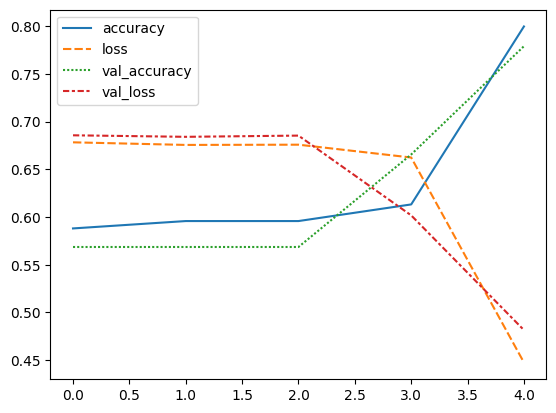

In [411]:
print('Building model', model_name)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)
sns.lineplot(history.history)
plt.show()

Building model LSTM-TF-IDF
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5521 - loss: 0.6907 - val_accuracy: 0.5345 - val_loss: 0.6922
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5766 - loss: 0.6765 - val_accuracy: 0.7308 - val_loss: 0.6127
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7753 - loss: 0.5589 - val_accuracy: 0.7610 - val_loss: 0.5576
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8098 - loss: 0.4896 - val_accuracy: 0.7538 - val_loss: 0.5409
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8386 - loss: 0.4410 - val_accuracy: 0.7603 - val_loss: 0.5294


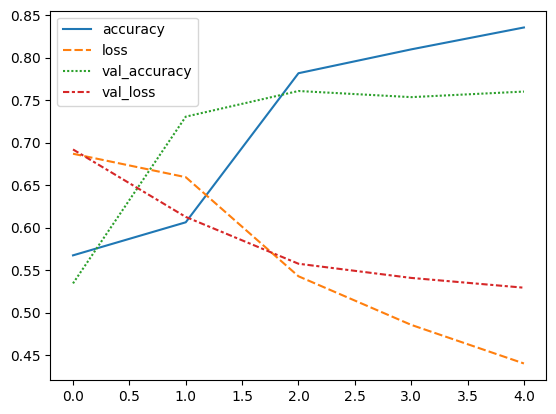

In [369]:
print('Building model', model_name)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit([x_train, tfidf_vectors], y_train, batch_size=32, epochs=5, validation_split=0.2)
sns.lineplot(history.history)
plt.show()

#### Save benchmarking

In [412]:
comparison_df = pd.DataFrame(history.history)
comparison_df['model'] = model_name
comparison_df['DoE'] = 'Baseline'
comparison_df.to_csv('model_comparison.csv', index=False, header=False, mode='a')


## Results and Analysis (35 pts)

*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*

Below is a list of some of the parameters amd hyperparameters explored.
* Feature size: 1k, 5k, 10k, 20k
* LSTM vs bi-directional LSTM vs LSTM with TF-IDF vs GRU
* 1 layer vs 2 layers vs 3 layers
* Number of units, dimensionality: 64, 128, 256

Feature size around 5k to 10k seemed to work best. All the models worked pretty good. Bi-directional LSTM and GRU worked slightly better. In general, two layers was enough and the larger the dimensionality the better, however the difference was not big. 



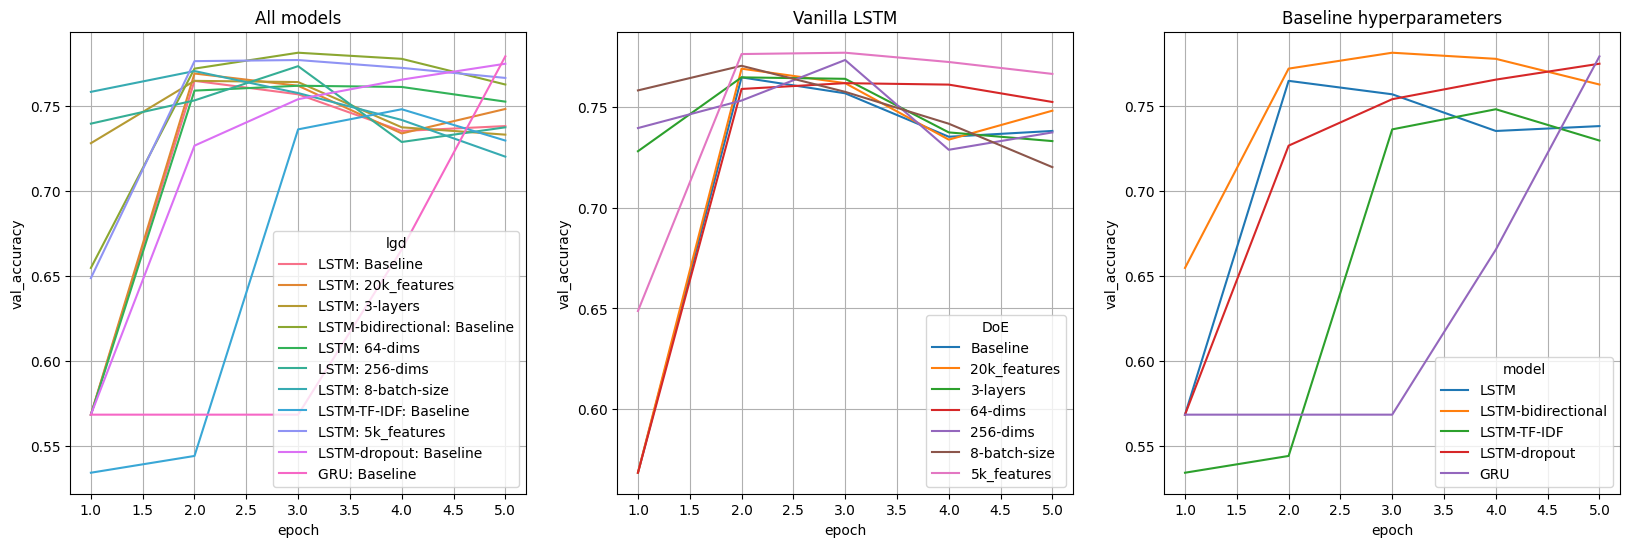

Top-5 models:


,accuracy,loss,val_accuracy,val_loss,model,DoE,epoch,lgd
17,0.858836,0.343805,0.781048,0.487795,LSTM-bidirectional,Baseline,3,LSTM-bidirectional: Baseline
54,0.799569,0.447570,0.778894,0.481525,GRU,Baseline,5,GRU: Baseline
18,0.899246,0.263863,0.777459,0.505856,LSTM-bidirectional,Baseline,4,LSTM-bidirectional: Baseline
42,0.844007,0.362775,0.776756,0.462070,LSTM,5k_features,3,LSTM: 5k_features
41,0.794417,0.452031,0.776100,0.475283,LSTM,5k_features,2,LSTM: 5k_features


In [423]:
plt.figure(figsize=(20, 6))

ax = plt.subplot(1, 3, 1)
sns.lineplot(comparison_df, x='epoch', y='val_accuracy', hue='lgd')
plt.grid()
plt.title('All models')
 
ax = plt.subplot(1, 3, 2)
comparison_df = pd.read_csv('model_comparison.csv')
comparison_df['epoch'] = [i+1 for i in range(5)] * 11
comparison_df['lgd'] = comparison_df['model'] + ': ' + comparison_df['DoE']
sns.lineplot(comparison_df.loc[comparison_df.model=='LSTM'], x='epoch', y='val_accuracy', hue='DoE')
plt.grid()
plt.title('Vanilla LSTM')

ax = plt.subplot(1, 3, 3)
sns.lineplot(comparison_df.loc[comparison_df.DoE=='Baseline'], x='epoch', y='val_accuracy', hue='model')
plt.grid()
plt.title('Baseline hyperparameters')
plt.show()

['LSTM: 5k-features', 'GRU: 256-dims']
print('Top-5 models:')
(comparison_df.sort_values('val_accuracy', ascending=False)[0:5])

#### Check that training accuracy can be reproduced

In [381]:
predictions = model.predict(x_train, verbose=False)
pred_label = np.round(predictions,0)
accu = []
for pred, act in zip(pred_label, y_train):
    accu.append(pred==act)
np.mean(accu)

np.float64(0.8711392041373366)

#### Submission

Code for predicting test data and saving it into a csv file.

In [382]:
predictions = model.predict(x_test, verbose=False)
pred_label = np.round(predictions,0)

In [383]:

test_df.id
print(x_test[0])
print(test_df.iloc[0])

submission_df = pd.DataFrame(test_df.id)
submission_df['target'] = pred_label.astype('int')
submission_df.head(5)
submission_df.to_csv('submission_3.csv', index=False)

tf.Tensor(
[  27  787    3 1738  133   98    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
id                                             0
keyword                                      NaN
location                                     NaN
text          Just happened a terrible car crash
word_count                                     6
Name: 0, dtype: object


## Conclusion (15 pts)

*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*

Improvements could be to stratify the training data to even out the label values, trying different activation functions and further cleaning the text.. 

In the end, most of the models performed with similar accuracy which suggest that more work on the text cleaning and processing could be beneficial. Some of the models could have benefitted having more epochs to train since the validation accuracy did not quite saturate yet. 

# Sources
https://keras.io/examples/nlp/bidirectional_lstm_imdb/

https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-implementation

https://keras.io/examples/nlp/text_classification_from_scratch/

